In [1]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

C:\Users\Dell\anaconda3\envs\birds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Dell\anaconda3\envs\birds\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


TensorFlow Version: 2.9.2
Model Maker Version: 0.3.4


In [2]:
data_dir = './palm_weevils/lab'

bird_code_to_name = {
  'clean': 'clean',
  'infested': 'infested',
}
birds_images = {
  'clean':  'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', # Alejandro Bayer Tamayo from Armenia, Colombia 
  'infested': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', # Diliff
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))
def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code =audio_path.split('\\')[-2]
  print(f'Bird name: {bird_code_to_name[bird_code]}')
  print(f'Bird code: {bird_code}')
  display(Image(birds_images[bird_code]))

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


Bird name: infested
Bird code: infested


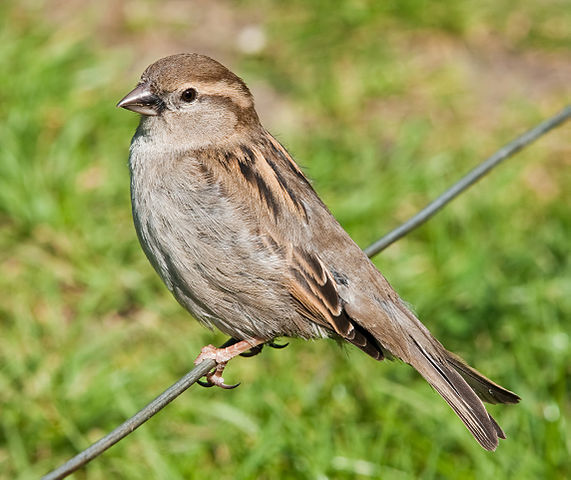

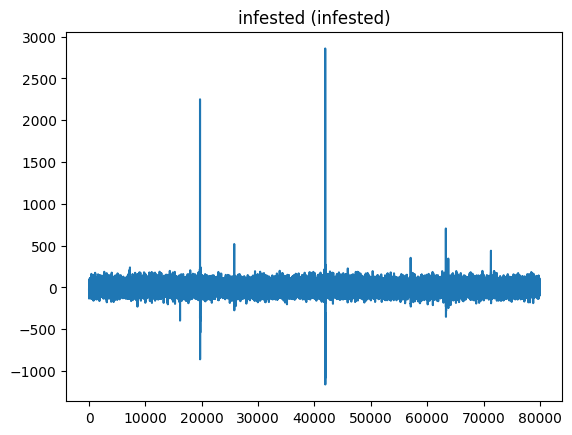

In [3]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [4]:
#classifier name is yamenetspec
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in C:\Users\Dell\AppData\Local\Temp\tmpvx9gqs7_


In [5]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [18]:
if tf.test.is_gpu_available():
    # Specify the GPU device to use
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [7]:
import tensorflow as tf

# Check if GPU is available and configured
if tf.test.is_gpu_available():
    # Verify the current device
    print("Current device:", tf.test.gpu_device_name())
else:
    print("GPU is not available or configured.")


Current device: /device:GPU:0


In [8]:
batch_size = 128
epochs = 10

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 2)                2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
479/479 [==============================] - 1909s 4s/step - loss: 0.0845 - acc: 0.9819 - val_loss: 0.0420 - val_acc: 0.9921
Epoch 2/10
479/479 [==============================] - 5s 11ms/step - loss: 0.0408 - acc: 0.9922 - val_loss: 0.0375 - val_acc: 0.9922
Epoch 3/10
479/479 [==============================] - 5s 11ms/step - loss: 0.0380 - acc: 0.9922 - val_loss: 0.0352 - val_acc: 0.9922
Epoch 4/10
479/479 [==============================] - 5s 10ms/step - loss: 0.0364 - acc: 0.9922 - val_loss: 0.0334 - val_acc: 0.9922
Epoch 5/10
479/479 [==========

In [9]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
513/513 [==============================] - 409s 795ms/step - loss: 0.0255 - acc: 0.9927


[0.025493301451206207, 0.9926811456680298]

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 30ms/step


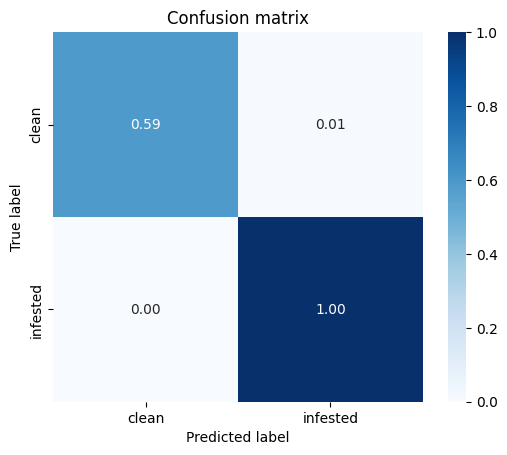

In [10]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)